# 03 - Repetition Bout Figures

## Imports

In [1]:
import avn.syntax as syntax
import avn.plotting as plotting
import avn.dataloading as dataloading

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

## Compile List of Birds

In [2]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "Y433", "Y453"] 

#All_Birds should contain 35 bird IDs. Check: 
len(All_Birds)

35

## Get Syllable Repetition Statistics - AVN Labels

In [4]:
syll_level_syntax_full = pd.DataFrame()

for Bird_ID in All_Birds:

    path_to_syll_df = "E:\\Final_Bird_Dataset\\UMAP_WSeg_labels_updated\\" + Bird_ID + '_labels.csv'

    syll_df = pd.read_csv(path_to_syll_df)

    if 'files_y' in syll_df.columns:
        syll_df['files'] = syll_df.files_y

    syll_df = syll_df[~syll_df.files.isna()]

    syntax_data = syntax.SyntaxData(Bird_ID, syll_df)

    song_folder_path = 'C:\\Grad_School\\Code_and_software\\Py_code\\March_2021_redo\\redo_data\\labeled_songs\\' 
   
    syntax_data.add_file_bounds(song_folder_path)
    syntax_data.add_gaps(min_gap = 0.2)
    syntax_data.drop_calls()
    syntax_data.make_transition_matrix()

    __, single_rep_stats = syntax_data.get_single_repetition_stats()
    intro_notes_df = syntax_data.get_intro_notes_df()
    prop_sylls_in_short_bouts = syntax_data.get_prop_sylls_in_short_bouts(max_short_bout_len=2)
    per_syll_stats = syntax.Utils.merge_per_syll_stats(single_rep_stats, prop_sylls_in_short_bouts, intro_notes_df)
    #get only syllable that aren't intro notes and that exist in bouts of 2 or less syllables in less than 1/3 of utterances
    per_syll_stats = per_syll_stats[(per_syll_stats.intro_note == False) & (per_syll_stats.prop_short_bout < 0.33)]
    #of those syllable types, select the one with the highest mean_repetition_length. 
    per_syll_stats = per_syll_stats.sort_values('mean_repetition_length', ascending = False)
    top_repeating_syll = pd.DataFrame(per_syll_stats[['mean_repetition_length', 'CV_repetition_length', 'Bird_ID']].iloc[0]).T
    top_repeating_syll['Bird_ID'] = Bird_ID
    syll_level_syntax_full = pd.concat([syll_level_syntax_full, top_repeating_syll])

In [5]:
syll_level_syntax_full.head(3)

,mean_repetition_length,CV_repetition_length,Bird_ID
9,1.9375,0.644354,B145
0,1.890244,0.826235,B236
5,1.162162,0.425016,B258


In [6]:
syll_level_syntax_full.to_csv('repetition_stats_wseg_umap.csv')

## Plot Mean repetition lengths

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
syll_level_syntax_full = pd.read_csv('repetition_stats_wseg_umap.csv')

In [28]:
all_birds = pd.read_csv("E:\\Final_Bird_Dataset\\old_Bird_list.csv")
syll_level_syntax_full = pd.merge(syll_level_syntax_full, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Typical', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Typical'}
syll_level_syntax_full['Group'] = [group_dict[x] for x in syll_level_syntax_full.Condition]

In [29]:
isolates_AVN = syll_level_syntax_full.mean_repetition_length[syll_level_syntax_full.Group== 'Isolate']
normal_AVN = syll_level_syntax_full.mean_repetition_length[syll_level_syntax_full.Group == 'Typical']
FP1_AVN = syll_level_syntax_full.mean_repetition_length[syll_level_syntax_full.Group == 'FP1 KD']

In [30]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [31]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN)
print(fvalue, pvalue)

1.09342689075131 0.34725899287358714


In [32]:
tukey = pairwise_tukeyhsd(endog = syll_level_syntax_full['mean_repetition_length'], 
                          groups = syll_level_syntax_full['Group'], 
                          alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 FP1 KD Isolate   0.0862  0.991 -1.5678 1.7402  False
 FP1 KD Typical  -0.6085 0.5421 -2.0119  0.795  False
Isolate Typical  -0.6947 0.4183 -2.0316 0.6423  False
-----------------------------------------------------


In [33]:
syll_level_syntax_full.Group = syll_level_syntax_full.Group.astype('category').cat.set_categories(['Typical', 'Isolate', 'FP1 KD'], ordered = True)

Text(0.5, 1.0, 'Mean Repetition Bout Length across Groups')

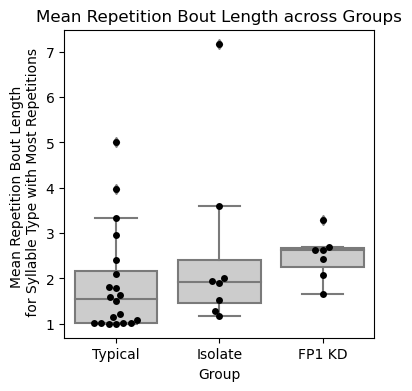

In [34]:
plt.figure(figsize = (4,4))
sns.boxplot(data = syll_level_syntax_full, x = 'Group', y = 'mean_repetition_length', color = '0.8')
sns.swarmplot(data = syll_level_syntax_full, x = 'Group', y = 'mean_repetition_length', color = 'black', s = 5)
plt.ylabel('Mean Repetition Bout Length \n for Syllable Type with Most Repetitions')
plt.title('Mean Repetition Bout Length across Groups')

## Plot CV Repetition Bout Lengths

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
syll_level_syntax_full = pd.read_csv('repetition_stats_wseg_umap.csv')

In [37]:
syll_level_syntax_full.head(2)

,Unnamed: 0,mean_repetition_length,CV_repetition_length,Bird_ID
0,9,1.937500,0.644354,B145
1,0,1.890244,0.826235,B236


In [38]:
all_birds = pd.read_csv("E:\\Final_Bird_Dataset\\old_Bird_list.csv")
syll_level_syntax_full = pd.merge(syll_level_syntax_full, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Typical', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Typical'}
syll_level_syntax_full['Group'] = [group_dict[x] for x in syll_level_syntax_full.Condition]

In [39]:
isolates_AVN = syll_level_syntax_full.CV_repetition_length[syll_level_syntax_full.Group== 'Isolate']
normal_AVN = syll_level_syntax_full.CV_repetition_length[syll_level_syntax_full.Group == 'Typical']
FP1_AVN = syll_level_syntax_full.CV_repetition_length[syll_level_syntax_full.Group == 'FP1 KD']

In [40]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [41]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN)
print(fvalue, pvalue)

4.645064920368697 0.016937904356646084


In [42]:
tukey = pairwise_tukeyhsd(endog = syll_level_syntax_full['CV_repetition_length'], 
                          groups = syll_level_syntax_full['Group'], 
                          alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 FP1 KD Isolate    0.024 0.9603 -0.1935  0.2416  False
 FP1 KD Typical  -0.1646 0.0882 -0.3492    0.02  False
Isolate Typical  -0.1886 0.0335 -0.3645 -0.0127   True
------------------------------------------------------


In [43]:
syll_level_syntax_full.Group = syll_level_syntax_full.Group.astype('category').cat.set_categories(['Typical', 'Isolate', 'FP1 KD'], ordered = True)

Text(0.5, 1.0, 'CV Repetition Bout Length across Groups')

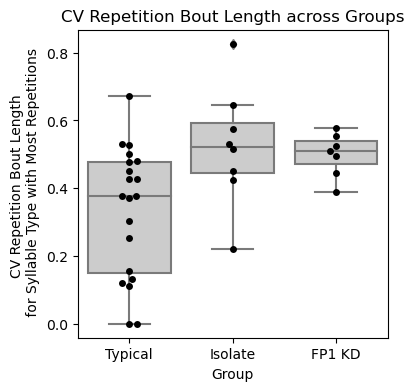

In [44]:
plt.figure(figsize = (4,4))
sns.boxplot(data = syll_level_syntax_full, x = 'Group', y = 'CV_repetition_length', color = '0.8')
sns.swarmplot(data = syll_level_syntax_full, x = 'Group', y = 'CV_repetition_length', color = 'black', s = 5)
plt.ylabel('CV Repetition Bout Length \n for Syllable Type with Most Repetitions')
plt.title('CV Repetition Bout Length across Groups')